## Импорт необходимых библиотек

In [1]:
!pip install tweet-preprocessor gensim kaggle scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import preprocessor as p
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import gensim
from sklearn.model_selection import train_test_split
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [3]:
seed = 2023
# np.random.RandomState = seed

## Анализ данных

In [4]:
api = KaggleApi()
api.authenticate()
api.dataset_download_files('kazanova/sentiment140')

In [5]:
with zipfile.ZipFile('sentiment140.zip', 'r') as zipref:
    zipref.extractall('sentiment140/')

In [6]:
colnames=['target', 'ids', 'date', 'flag', 'user', 'text']
data = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv", encoding='cp1252', names=colnames, header=None)
data.sample()

,target,ids,date,flag,user,text
1279206,4,2001509548,Tue Jun 02 01:07:09 PDT 2009,NO_QUERY,pareidoliac,"so, having come to the end of the line with my..."


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
data.drop(['ids', 'date', 'flag', 'user'], axis=1, inplace=True)
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


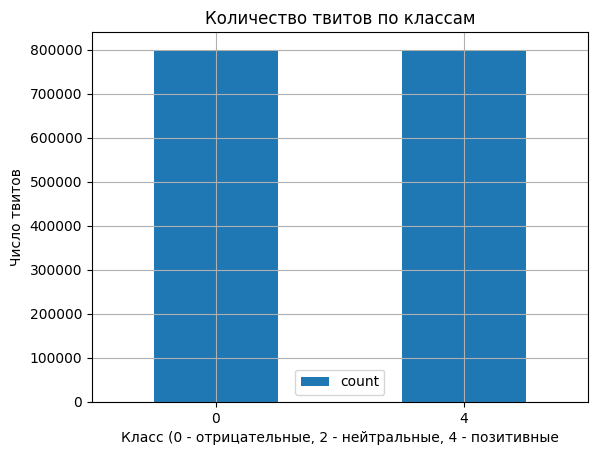

In [9]:
data['target'].value_counts().plot(
    kind='bar',
    rot=0,
    title='Количество твитов по классам',
    xlabel='Класс (0 - отрицательные, 2 - нейтральные, 4 - позитивные',
    ylabel='Число твитов',
    legend=True,
    grid=True
);

Класса получается всего 2, поэтому мы будем делать бинарную классификацию. Заменим метку класса 4 на 1:

In [10]:
data['target'] = data['target'].replace(4,1)

## Предобработка данных

In [11]:
print(STOPWORDS)

frozenset({'both', 'could', 'show', 'who', 'everything', 'bill', 'others', 'hereby', 'fifteen', 'anyone', 'noone', 'interest', 'we', 'fill', 'was', 'third', 'ie', 'very', 'into', 'doing', 'elsewhere', 'many', 'well', 'whereby', 'hundred', 'much', 'thence', 'de', 'mine', 'thereby', 'hers', 'besides', 'nor', 'while', 'couldnt', 'using', 'whatever', 'cannot', 'everywhere', 'else', 'than', 'you', 'only', 'formerly', 'their', 'yourselves', 'least', 'un', 'full', 'it', 'would', 'thru', 'various', 'say', 'really', 'should', 'used', 'everyone', 'above', 'almost', 'his', 'behind', 'he', 'may', 'she', 'anyhow', 'kg', 'must', 'something', 'because', 'neither', 'me', 'former', 'himself', 'herself', 'one', 'put', 'enough', 'eg', 'seemed', 'part', 'always', 'this', 'amongst', 'ever', 'name', 'except', 'upon', 'towards', 'during', 'off', 'might', 'from', 'most', 'whereafter', 'were', 'an', 'go', 'last', 'three', 'him', 'none', 'some', 'nothing', 'didn', 'all', 'nobody', 'serious', 'somewhere', 'mill'

Данные стоп слова вряд ли влияют на настроение твита, так что возьму их прямо из коробки.

In [12]:
%%time
def preprocess_tweet(row):
    text = row['text']
    text = p.clean(text)
    text = remove_stopwords(text)
    return text.lower().replace('\s\s+', ' ')

data['cleaned_text'] = data.apply(preprocess_tweet, axis=1)

CPU times: total: 2min 43s
Wall time: 2min 44s


In [13]:
data.sample(10)

,target,text,cleaned_text
945166,1,"&quot;First we was chillin, now catchin feelin...","&quot;first chillin, catchin feelins.&quot;"
1368784,1,i am playing the wii right now with all of my ...,playing wii right family. having blast played ...
1397813,1,Syurga Cinta was good...,syurga cinta good...
472502,0,@rhettroberts but i thought there was no secr...,thought secrets us.
340342,0,No prayer night. I'm so sad.,no prayer night. i'm sad.
956971,1,Making a ton of videos,making ton videos
654029,0,is not looking forward to school induction day...,looking forward school induction day..eugh lik...
1384373,1,oh. and i also got sims 3,oh. got sims
522016,0,@breakingdawn i steal from your farm every day...,steal farm day klepto need cash moneyyy haha me!
1376998,1,"im new to this twitter thingy, so if any fanci...","im new twitter thingy, fancies letting know us..."


## Извлечение признаков из текста с помощью векторизации

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['target'], random_state=2023)

In [15]:
%%time
VECTOR_SIZE = 256
model = gensim.models.FastText(
    sentences=X_train,
    vector_size=VECTOR_SIZE, # default = 100
    window=7, # default = 5
    min_count=10,
    sg=1, # Training algorithm: 1 for skip-gram; otherwise CBOW
    hs=0, #  If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
    negative=5, # If > 0, negative sampling will be used, if set to 0, no negative sampling is used.
    epochs=25, # Number of iterations (epochs) over the corpus
    seed=seed,
)

CPU times: total: 53min
Wall time: 18min 47s


In [16]:
# Получаем эмбеддинг для текста
def document_vector(doc):
    doc = [model.wv[word] for word in doc if word in model.wv.key_to_index.keys()]
    if not doc:
        return [0 for i in range(VECTOR_SIZE)]
    return np.mean(doc, axis=0)

X_train_vectorized = list(X_train.apply(document_vector))
X_test_vectorized = list(X_test.apply(document_vector))

## Бейзлайн - константное предсказание

In [17]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=seed).fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67    199541
           1       0.00      0.00      0.00    200459

    accuracy                           0.50    400000
   macro avg       0.25      0.50      0.33    400000
weighted avg       0.25      0.50      0.33    400000



## Логистическая регрессия

In [18]:
logreg = LogisticRegression(random_state=seed).fit(X_train_vectorized, y_train)
preds_count_vec = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds_count_vec))

C:\Users\User\IdeaProjects\2\sentiment_classification\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.59      0.64      0.61    199541
           1       0.61      0.55      0.58    200459

    accuracy                           0.60    400000
   macro avg       0.60      0.60      0.60    400000
weighted avg       0.60      0.60      0.60    400000

